In [2]:
!pip install vaderSentiment sqlite-utils


In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json, sqlite3
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

DATA = Path("../data")


In [3]:
us = pd.read_csv(DATA/"USvideos.csv")
us["region"] = "US"

# Optional:
gb_path = DATA/"GBvideos.csv"
if gb_path.exists():
    gb = pd.read_csv(gb_path)
    gb["region"] = "GB"
    df = pd.concat([us, gb], ignore_index=True)
else:
    df = us.copy()

df.shape, df.columns.tolist()[:12]


((79865, 17),
 ['video_id',
  'trending_date',
  'title',
  'channel_title',
  'category_id',
  'publish_time',
  'tags',
  'views',
  'likes',
  'dislikes',
  'comment_count',
  'thumbnail_link'])

In [5]:
keep = ["video_id","title","channel_title","category_id",
        "publish_time","trending_date","views","likes","dislikes",
        "comment_count","tags","region"]
df = df[keep].copy()

# trending_date in Kaggle is often 'yy.dd.mm' (e.g., 17.14.11)
def parse_trending(d):
    for fmt in ("%y.%d.%m", "%y.%m.%d", "%Y-%m-%d", "%d.%m.%Y"):
        try:
            return pd.to_datetime(d, format=fmt)
        except:
            pass
    return pd.to_datetime(d, errors="coerce")

df["trending_date"] = df["trending_date"].apply(parse_trending)
df["publish_time"] = pd.to_datetime(df["publish_time"], errors="coerce")


In [6]:
df.drop_duplicates(subset=["video_id","trending_date","region"], inplace=True)

# Replace negatives (rare data glitches)
for col in ["views","likes","dislikes","comment_count"]:
    df[col] = df[col].clip(lower=0)

df["likes_to_views"] = np.where(df["views"]>0, df["likes"]/df["views"], 0.0)
df["engagement_rate"] = np.where(df["views"]>0,
                                 (df["likes"]+df["comment_count"])/df["views"], 0.0)

df["year_month"] = df["trending_date"].dt.to_period("M").astype(str)
df["year"] = df["trending_date"].dt.year
df["month"] = df["trending_date"].dt.month
df.head(3)


,video_id,title,channel_title,category_id,publish_time,trending_date,views,likes,dislikes,comment_count,tags,region,likes_to_views,engagement_rate,year_month,year,month
0,2kyS6SvSYSE,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01+00:00,2017-11-14,748374,57527,2966,15954,SHANtell martin,US,0.076869,0.098188,2017-11,2017,11
1,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,2017-11-14,2418783,97185,6146,12703,"last week tonight trump presidency|""last week ...",US,0.040179,0.045431,2017-11,2017,11
2,5qpjK5DgCt4,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,2017-11-14,3191434,146033,5339,8181,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",US,0.045758,0.048321,2017-11,2017,11


In [7]:
analyzer = SentimentIntensityAnalyzer()

def sent(x):
    try: return analyzer.polarity_scores(str(x))["compound"]
    except: return 0.0

df["title_sentiment"] = df["title"].apply(sent)
df["tags_sentiment"]  = df["tags"].apply(sent)


In [8]:
trending_days = (df.groupby(["video_id","region"])["trending_date"]
                   .nunique()
                   .reset_index(name="trending_duration_days"))

# Join back if useful
df = df.merge(trending_days, on=["video_id","region"], how="left")


In [9]:
OUT = DATA/"youtube_trending_clean.csv"
df.to_csv(OUT, index=False)
OUT


WindowsPath('../data/youtube_trending_clean.csv')

In [10]:
conn = sqlite3.connect("../youtube_trending.db")
df.to_sql("youtube_trending", conn, if_exists="replace", index=False)

# Quick sanity
pd.read_sql("SELECT COUNT(*) AS rows FROM youtube_trending;", conn)


,rows
0,79641


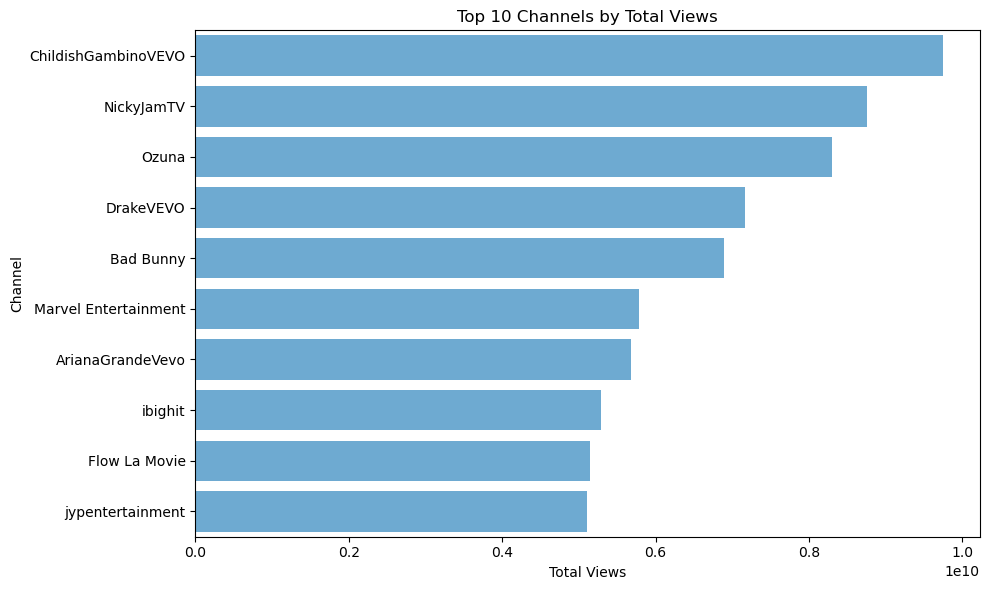

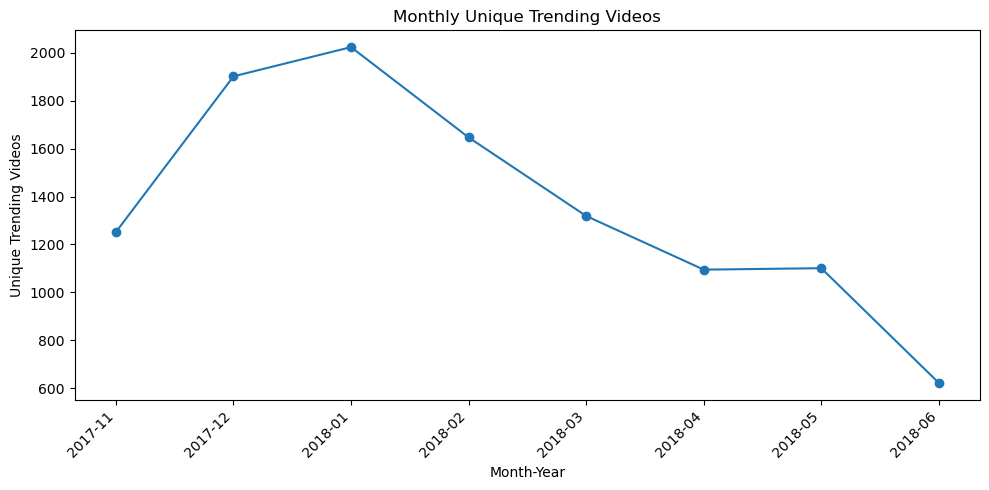

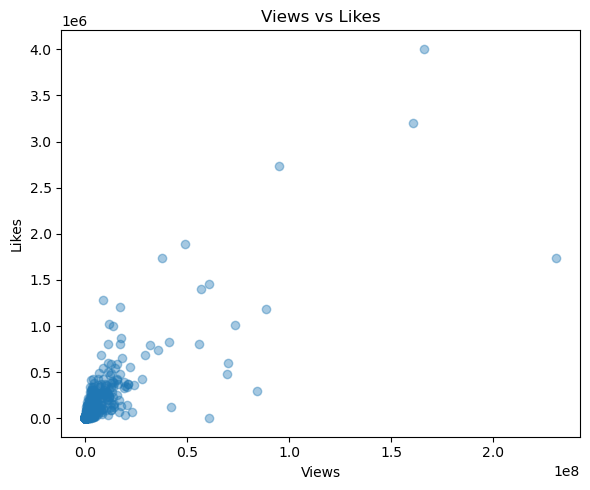

In [11]:
# Top 10 channels by total views
top_channels = (df.groupby("channel_title")["views"]
                  .sum().sort_values(ascending=False).head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=top_channels.values, y=top_channels.index, color="#5DADE2")
plt.title("Top 10 Channels by Total Views")
plt.xlabel("Total Views"); plt.ylabel("Channel")
plt.tight_layout(); plt.show()

# Monthly trend of unique trending videos (all regions combined)
monthly = (df.groupby("year_month")["video_id"]
             .nunique().rename("unique_trending_videos").reset_index())

plt.figure(figsize=(10,5))
plt.plot(monthly["year_month"], monthly["unique_trending_videos"], marker="o")
plt.title("Monthly Unique Trending Videos")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Month-Year"); plt.ylabel("Unique Trending Videos")
plt.tight_layout(); plt.show()

# Views vs Likes (sample 1000 for speed)
sample = df.sample(min(1000, len(df)), random_state=42)
plt.figure(figsize=(6,5))
plt.scatter(sample["views"], sample["likes"], alpha=0.4)
plt.title("Views vs Likes")
plt.xlabel("Views"); plt.ylabel("Likes")
plt.tight_layout(); plt.show()


In [12]:
import sqlite3
import pandas as pd

# connect to DB
conn = sqlite3.connect("../youtube_trending.db")


In [14]:
# Read all SQL queries from file
with open("../sql/youtube_trending.sql", "r") as f:
    sql_script = f.read()

# Split into individual queries (they end with ;)
queries = [q.strip() for q in sql_script.split(";") if q.strip()]


In [15]:
with open("../sql/youtube_trending.sql", "r") as f:
    sql_script = f.read()

queries = [q.strip() for q in sql_script.split(";") if q.strip()]

for i, query in enumerate(queries, 1):
    try:
        print(f"\n--- Query {i} ---")
        result = pd.read_sql(query, conn)
        display(result.head())
    except Exception as e:
        print(f"Error in Query {i}: {e}")



--- Query 1 ---


,category,total_views
0,10,210540510080
1,24,50173412625
2,1,15581745480
3,22,10654820704
4,23,9048351270



--- Query 2 ---


,category,avg_views
0,10,1.044089e+07
1,29,3.549249e+06
2,1,3.175412e+06
3,24,2.640984e+06
4,17,1.899674e+06



--- Query 3 ---


,region,avg_views,avg_engagement_rate
0,GB,5.911516e+06,0.038039
1,US,2.360649e+06,0.038870



--- Query 4 ---


,month_year,region,unique_trending_videos
0,2006-07,US,1
1,2007-03,GB,1
2,2007-06,GB,1
3,2007-12,GB,1
4,2008-01,GB,1



--- Query 5 ---


,region,avg_trending_days,max_trending_days
0,US,1.0,3
1,GB,1.0,1



--- Query 6 ---


,category,avg_title_sentiment,avg_tags_sentiment
0,19,0.156,0.034
1,2,0.118,0.123
2,26,0.105,0.073
3,17,0.078,0.063
4,15,0.067,0.066
